In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import expit
from collections import namedtuple
from ipywidgets import IntProgress
# from IPython.display import display

import gpflow
from gpflow.utilities import print_summary, positive

import tensorflow as tf
from tensorflow import math as tfm
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd
from tensorflow_probability import mcmc
import pymc3 as pm
import arviz

from load_puma_data import load_barenco_puma
from MetropolisCustomProposal import MetropolisCustomProposal
import math
import random
import time

PI = tf.constant(math.pi, dtype='float64')
plt.style.use('ggplot')
%matplotlib inline



WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df, genes, genes_se, Y, Y_var = load_barenco_puma()


N_m = 7               # Number of observations
def calc_N_p(N_p, num_disc=8):
    '''A helper recursive function to ensure t is a subset of τ'''
    if num_disc <= 0:
        return N_p
    return N_p -1 + calc_N_p(N_p, num_disc-1)
num_disc = 10
N_p = calc_N_p(N_m, num_disc)  # Number of time discretisations
common_indices = np.array([i*num_disc+i for i in range(N_m)])
t = np.arange(N_m)*2           # Observation times
τ = np.linspace(0, 12, N_p, dtype='float64')    # Discretised observation times
num_genes = 5
I = 1 # Number of TFs

m_observed = np.float64(Y[:-1])
f_observed = np.float64(np.atleast_2d(Y[-1]))
σ2 = np.float64(Y_var[:-1])
σ2_f = np.float64(np.atleast_2d(Y_var[-1]))


In [3]:
f64 = np.float64
def get_rbf_dist(times, N):
    t_1 = np.reshape(np.tile(times, N), [N, N]).T
    t_2 = np.reshape(np.tile(times, N), [N, N])
    return t_1-t_2

def jitter_cholesky(A):
    try:
        jitter1 = tf.linalg.diag(1e-7 * np.ones(A.shape[0]))
        return tf.linalg.cholesky(A + jitter1)
    except:
        jitter2 = tf.linalg.diag(1e-5 * np.ones(A.shape[0]))
        return tf.linalg.cholesky(A + jitter2)

info = np.finfo('float64')
def exp(x):
    '''Safe exp'''
    with np.errstate(under='ignore', over='ignore'):
        return np.exp(x)
    
def mult(a, b):
    '''Safe multiplication'''
    with np.errstate(under='ignore', over='ignore', invalid='ignore'):
        c = a*b
        return np.where(np.isnan(c), 0, c)

In [14]:
tt.drow

TensorType(float64, row)

In [46]:
import theano.tensor as tt
class TranscriptionLikelihood(tt.Op):

    itypes = [tt.dvector, tt.drow] # expects a vector of parameter values when called
    otypes = [tt.dvector] # outputs a  value (the log likelihood)

    def __init__(self):
        pass

    def perform(self, node, inputs, outputs):
        δbar, fbar = inputs
        # print('theta', theta)
        logl = self.genes(δbar=δbar[0], fbar=fbar[0])

        outputs[0][0] = (logl) 

    def predict_m(self, kbar, δbar, w, fbar, w_0):
        # Take relevant parameters out of log-space
        a_j, b_j, d_j, s_j = (np.exp(kbar[:, i]).reshape(-1, 1) for i in range(4))
        δ = np.exp(δbar)
        f_i = np.log(1+np.exp(fbar))

        # Calculate p_i vector
        p_i = np.zeros(N_p) # TODO it seems the ODE translation model has params A, S see gpmtfComputeTFODE
        Δ = τ[1]-τ[0]
        sum_term = mult(exp(δ*τ), f_i)
        p_i[1:] = 0.5*Δ*np.cumsum(sum_term[:-1] + sum_term[1:]) # Trapezoid rule
#         try:
        p_i = mult(exp(-δ*τ), p_i)
#         except:
#             print(exp(-δ*τ), p_i)
    #     print('pi', p_i)

        # Calculate m_pred
        integrals = np.zeros((num_genes, N_p))
        interactions = w[:, 0][:, None]*np.log(p_i+1e-100) + w_0
        G = expit(interactions) # TF Activation Function (sigmoid)
        sum_term = G * exp(d_j*τ)
        integrals[:, 1:] = 0.5*Δ*np.cumsum(sum_term[:, :-1] + sum_term[:, 1:], axis=1) # Trapezoid rule
        exp_dt = exp(-d_j*τ)
        integrals = mult(exp_dt, integrals)
        m_pred = b_j/d_j + mult((a_j-b_j/d_j), exp_dt) + s_j*integrals

        return m_pred

    def genes(self, δbar=None,
                    fbar=None, 
                    kbar=None, 
                    w=None,
                    σ2_m=None):
        '''
        Computes likelihood of the genes.
        If any of the optional args are None, they are replaced by their current value in params.
        '''
        if δbar is None:
            δbar = 0.1
        if fbar is None:
            fbar = 0.5*np.ones(N_p)
        if kbar is None:
            kbar = -0.1*np.float64(np.c_[
                np.ones(num_genes), # a_j
                np.ones(num_genes), # b_j
                np.ones(num_genes), # d_j
                np.ones(num_genes)  # s_j
            ])

        w = np.ones((num_genes, I)) if w is None else w
        σ2_m = 1e-4*np.ones(num_genes) if σ2_m is None else σ2_m

        w_0 = 0 # TODO no hardcode this!
        m_pred = self.predict_m(kbar, δbar, w, fbar, w_0)

        log_lik = np.zeros(num_genes)
        sq_diff = np.square(m_observed - m_pred[:, common_indices])
        variance = σ2_m.reshape(-1, 1) + σ2 # add PUMA variance
        log_lik = -0.5*np.log(2*np.pi*(variance)) - 0.5*sq_diff/variance
        log_lik = np.sum(log_lik, axis=1)

        return log_lik

    def tfs(self, fbar, i=0): 
        '''
        Computes log-likelihood of the transcription factors.
        TODO this should be for the i-th TF
        '''
        f_pred = np.log(1+np.exp(fbar))
        f_pred = np.atleast_2d(f_pred[common_indices])
        sq_diff = np.square(f_observed[i] - f_pred[i])
        log_lik = -0.5*sum(np.log(2*np.pi*σ2_f[i])) - 0.5*sum(sq_diff/σ2_f[i])
        return log_lik

likelihood = TranscriptionLikelihood()

initial_kbar = -0.1*np.float64(np.c_[
    np.ones(num_genes), # a_j
    np.ones(num_genes), # b_j
    np.ones(num_genes), # d_j
    np.ones(num_genes)  # s_j
])
initial_fbar = 0.5*np.ones(N_p, dtype='float64')

current_state=[tf.constant(f64(-0.3)), initial_fbar, initial_kbar]



In [47]:
h_δ = 0.25 * np.ones(1)
h_f = 0.35*tf.ones(N_p, dtype='float64')
a = 0
b2 = 2
v = 4
l2 = 8
jitter = tf.linalg.diag(1e-5 * np.ones(N_p))
t_dist = get_rbf_dist(τ, N_p)

def prop_dist(fbar, h_f):
    # Gibbs step
    z_i = tf.reshape(tfd.MultivariateNormalDiag(fbar, h_f).sample(), (1, -1))
    # MH
    K = mult(v, exp(-np.square(t_dist)/(2*l2))) + jitter
    invKsigmaK = tf.matmul(tf.linalg.inv(K+tf.linalg.diag(h_f)), K) # (C_i + hI)C_i
    L = jitter_cholesky(K-tf.matmul(K, invKsigmaK))
    c_mu = tf.matmul(z_i, invKsigmaK)
    fstar = tf.matmul(tf.random.normal((1, L.shape[0]), dtype='float64'), L) + c_mu
    fstar = tf.reshape(fstar, (-1, ))
    return fstar
with pm.Model() as model:
    δbar = pm.Normal('δbar', a, b2)#, f64(-0.3), proposal_dist=lambda mu:tfd.Normal(mu, self.h_δ)

    step = pm.Metropolis([δbar], S=h_δ) #lambda mu:tfd.Normal(mu, h_δ)

    K = mult(v, exp(-np.square(t_dist)/(2*l2))) + jitter
    m = np.zeros(N_p)
    fbar = pm.MvNormal('fbar', mu=m, cov=K, shape=(N_p))

    step_f = MetropolisCustomProposal([fbar], S=0.35*tf.ones(N_p, dtype='float64'), proposal_dist=prop_dist)

    var_δbar = tt.as_tensor_variable([δbar])
    var_fbar = tt.as_tensor_variable([fbar])
    y = pm.DensityDist('likelihood', lambda v, f: likelihood(v, f), observed={'v': var_δbar, 'f': var_fbar})

    trace = pm.sample(step=[step, step_f])

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [δbar]
>MetropolisCustomProposal: [fbar]
Could not pickle model, sampling singlethreaded.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [δbar]
>MetropolisCustomProposal: [fbar]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:07<00:00, 134.50it/s]
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [92]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
δbar,0.005,1.902,-3.756,3.535,0.122,0.094,242.0,207.0,247.0,220.0,1.00
fbar[0],-0.335,1.640,-3.361,2.869,0.504,0.411,11.0,9.0,11.0,14.0,1.18
fbar[1],-0.345,1.625,-3.329,2.909,0.525,0.411,10.0,8.0,10.0,13.0,1.19
fbar[2],-0.377,1.604,-2.951,3.145,0.537,0.435,9.0,7.0,9.0,12.0,1.22
fbar[3],-0.406,1.608,-3.006,3.097,0.550,0.430,9.0,8.0,9.0,12.0,1.23
...,...,...,...,...,...,...,...,...,...,...,...
fbar[62],-0.546,0.875,-1.958,1.230,0.431,0.330,4.0,4.0,4.0,28.0,1.46
fbar[63],-0.548,0.882,-2.011,1.175,0.432,0.330,4.0,4.0,4.0,30.0,1.46
fbar[64],-0.548,0.888,-2.026,1.198,0.433,0.330,4.0,4.0,4.0,27.0,1.46
fbar[65],-0.546,0.895,-2.099,1.157,0.431,0.328,4.0,4.0,4.0,25.0,1.45


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_attrs', '_report', '_slice', '_straces', 'add_values', 'chains', 'get_sampler_stats', 'get_values', 'nchains', 'point', 'points', 'remove_values', 'report', 'stat_names', 'varnames']


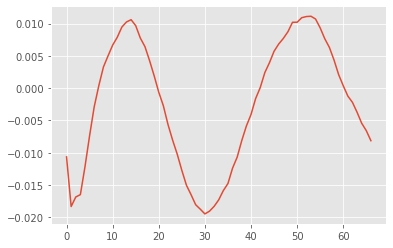

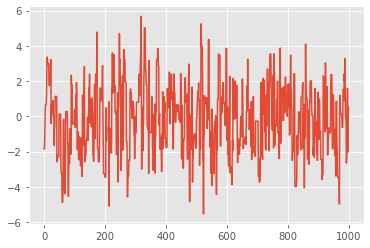

In [48]:
print(dir(trace))
plt.plot(trace.get_values(varname='fbar')[-1])
plt.figure()
plt.plot(trace.get_values(varname='δbar'))
print(trace.points())

In [91]:
fbar

fbar